# Tn-seq peak data analysis

### This notebook is designed to acheive the following:
* Plot raw numbers of reads across samples and identify outliers
* Plot the distributions of fold changes across ranked samples
* Identify the intersection of annotated genes across samples

In [1]:
## Import modules
import pandas as pd
import numpy as np
import glob
import os
import sys
import time 
import seaborn as sns
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

plt.style.use('seaborn-ticks')

from IPython.display import clear_output


In [2]:
np.__version__

'1.20.3'

#### Load files

In [8]:
# MAE-001
peaks_directory_001 = '../../tn-seq_data/tn-seq_outputs/mae-001/annotated_peaks/'
export_directory_001 = '../../tn-seq_data/tn-seq_outputs/mae-001/figures/'
peaks_directory_001_dedup = '../../tn-seq_data/tn-seq_outputs/mae-001/annotated_peaks_dedup/'
export_directory_001_dedup = '../../tn-seq_data/tn-seq_outputs/mae-001/figures_dedup/'
metadatafile_path_001 = '/Users/attienglish/Dropbox (MIT)/PhD Project/6_GRN_evolution/tn-seq_data/Quintara_NGS_Raw/2021-11-15_tn107-109_p146_arbutin_MiSeq/Fastq/mae-001_metadata.txt'
metadatafile_001 = pd.read_csv(metadatafile_path_001,sep="\t")
dedup_stats_001 = pd.read_csv('../../tn-seq_data/tn-seq_outputs/mae-001/bowtie2_output_dedup/deduplication_stats.csv',sep=",")


# MAE-002
peaks_directory_002 = '../../tn-seq_data/tn-seq_outputs/mae-002/annotated_peaks/'
export_directory_002 = '../../tn-seq_data/tn-seq_outputs/mae-002/figures/'
peaks_directory_002_dedup = '../../tn-seq_data/tn-seq_outputs/mae-002/annotated_peaks_dedup/'
export_directory_002_dedup = '../../tn-seq_data/tn-seq_outputs/mae-002/figures_dedup/'
metadatafile_path_002 = '/Users/attienglish/Dropbox (MIT)/PhD Project/6_GRN_evolution/tn-seq_data/Quintara_NGS_Raw/2021-11-23_MAE-002_tn107-109_p146_arbutin_HiSeqX/Fastq/mae-002_metadata.txt'
metadatafile_002 = pd.read_csv(metadatafile_path_002,sep="\t")
#dedup_stats_002 = pd.read_csv('../../tn-seq_data/tn-seq_outputs/mae-002/bowtie2_output_dedup/deduplication_stats.csv',sep=",")


# MAE-003
peaks_directory_003 = '../../tn-seq_data/tn-seq_outputs/mae-003/annotated_peaks/'
export_directory_003 = '../../tn-seq_data/tn-seq_outputs/mae-003/figures/'
peaks_directory_003_dedup = '../../tn-seq_data/tn-seq_outputs/mae-003/annotated_peaks_dedup/'
export_directory_003_dedup = '../../tn-seq_data/tn-seq_outputs/mae-003/figures_dedup/'
metadatafile_path_003 = '/Users/attienglish/Dropbox (MIT)/PhD Project/6_GRN_evolution/tn-seq_data/Quintara_NGS_Raw/mae-003_metadata.txt'
metadatafile_003 = pd.read_csv(metadatafile_path_003,sep="\t")
dedup_stats_003 = pd.read_csv('../../tn-seq_data/tn-seq_outputs/mae-003/bowtie2_output_dedup/deduplication_stats.csv',sep=",")


# MAE-004
peaks_directory_004 = '../../tn-seq_data/tn-seq_outputs/mae-004/annotated_peaks/'
export_directory_004 = '../../tn-seq_data/tn-seq_outputs/mae-004/figures/'
peaks_directory_004_dedup = '../../tn-seq_data/tn-seq_outputs/mae-004/annotated_peaks_dedup/'
export_directory_004_dedup = '../../tn-seq_data/tn-seq_outputs/mae-004/figures_dedup/'
metadatafile_path_004 = '/Users/attienglish/Documents/NGS_data_archive/2022-02-03_MAE-004_MDS42_MG1655_scrape_plate_LB-ON_HiSeqX/Fastq/mae-004_metadata.txt'
metadatafile_004 = pd.read_csv(metadatafile_path_004,sep="\t")
dedup_stats_004 = pd.read_csv('../../tn-seq_data/tn-seq_outputs/mae-004/bowtie2_output_dedup/deduplication_stats.csv',sep=",")


# MAE-005
peaks_directory_005 = '../../tn-seq_data/tn-seq_outputs/mae-005/annotated_peaks/'
export_directory_005 = '../../tn-seq_data/tn-seq_outputs/mae-005/figures/'
peaks_directory_005_dedup = '../../tn-seq_data/tn-seq_outputs/mae-005/annotated_peaks_dedup/'
export_directory_005_dedup = '../../tn-seq_data/tn-seq_outputs/mae-005/figures_dedup/'
metadatafile_path_005 = '/Users/attienglish/Documents/NGS_data_archive/2022-02-16_MAE-005_tn114-117_activator_trials_v2_HiSeqX/Fastq/mae-005_metadata.txt'
metadatafile_005 = pd.read_csv(metadatafile_path_005,sep="\t")
dedup_stats_005 = pd.read_csv('../../tn-seq_data/tn-seq_outputs/mae-005/bowtie2_output_dedup/deduplication_stats.csv',sep=",")

# Defined pairs to plot samples
pairs_001 = [[1,2],[3,4],[5,6],[7,8],[9,10]] # Note, none of these are actually paired
pairs_002 = [[1,2],[3,4],[5,6],[7,8],[9,10]] # Note, none of these are actually paired
pairs_003 = [[1,13],[2,14],[3,15],[4,16],[5,17],[6,18],[7,19],[8,20],[9,21],[10,22],[11,23],[12,24]]
pairs_004 = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16],[17,18],[19,20],[21,22],[23,24]]
pairs_005 = [[12,1],[13,2],[14,3],[15,4],[16,5],[17,6],[18,7],[19,8],[20,9],[21,10],[22,11],[23,24]]

metadatafile_005.head()

,sample_number,experiment_name,sample_name,sample_type,strain_name,helper_plasmid,outgrowth_media,inducer,total_reads_postQC,donor_plasmid
0,1,mae-005,01_S95_L002_R1_001.fastq.gz,endpoint,MDS42,pENG133,arbutin,atc,25.921124,pENG146
1,2,mae-005,02_S96_L002_R1_001.fastq.gz,endpoint,MDS42,pENG133,arbutin,atc,20.480946,pENG146
2,3,mae-005,03_S97_L002_R1_001.fastq.gz,endpoint,MDS42,pENG133,arbutin,atc,27.714412,pENG146
3,4,mae-005,04_S98_L002_R1_001.fastq.gz,endpoint,MDS42,pENG133,arbutin,atc,32.673738,pENG146
4,5,mae-005,05_S99_L002_R1_001.fastq.gz,endpoint,MDS42,pENG133,arbutin,atc,26.502220,pENG146


### Compare numbers of reads

Samples [] are outliers


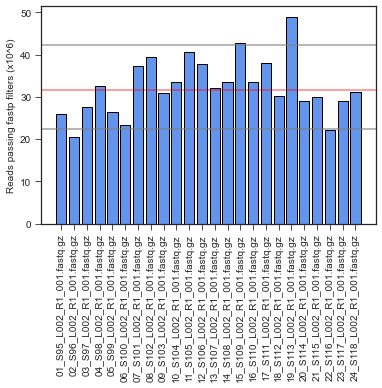

In [42]:
## Plot number of reads per sample
reads_per_sample(metadatafile_001,export_directory_001,'x10^3')
reads_per_sample(metadatafile_002,export_directory_002,'x10^6')
reads_per_sample(metadatafile_003,export_directory_003,'x10^6')
reads_per_sample(metadatafile_004,export_directory_004,'x10^6')
reads_per_sample(metadatafile_005,export_directory_005,'x10^6')

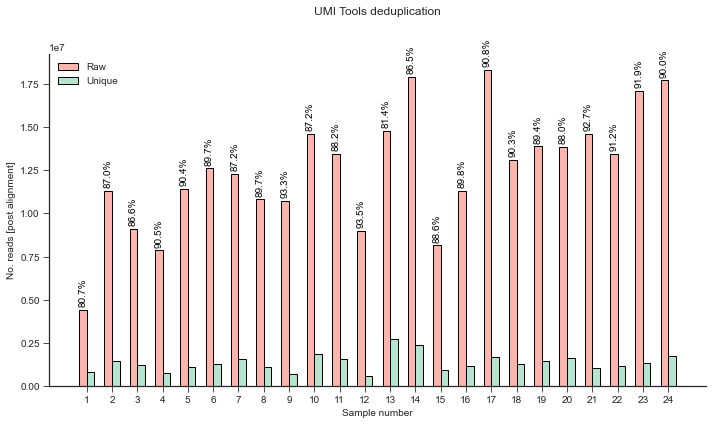

In [546]:
#dedup_read_comparison(dedup_stats_001,export_directory_001_dedup)
#dedup_read_comparison(dedup_stats_002,export_directory_002_dedup)
dedup_read_comparison(dedup_stats_003,export_directory_003_dedup)
#dedup_read_comparison(dedup_stats_004,export_directory_004_dedup)
#dedup_read_comparison(dedup_stats_005,export_directory_005_dedup)

### Plot fold enrichment distributions for the peaks

In [6]:
metadata_zip_001 = metadata_collection(peaks_directory_001)
plot_all_ranked_distributions(5,2,metadata_zip_001,export_directory_001,metadatafile_001)
metadata_zip_002 = metadata_collection(peaks_directory_002)
plot_all_ranked_distributions(5,2,metadata_zip_002,export_directory_002,metadatafile_002)
metadata_zip_003 = metadata_collection(peaks_directory_003)
plot_all_ranked_distributions(8,3,metadata_zip_003,export_directory_003,metadatafile_003)
metadata_zip_004 = metadata_collection(peaks_directory_004)
plot_all_ranked_distributions(8,3,metadata_zip_004,export_directory_004,metadatafile_004)
metadata_zip_005 = metadata_collection(peaks_directory_005)
plot_all_ranked_distributions(8,3,metadata_zip_005,export_directory_005,metadatafile_005)

NameError: name 'metadata_collection' is not defined

In [5]:

#metadata_zip_001 = metadata_collection(peaks_directory_001)
#plot_paired_ranked_distributions(pairs_001,metadata_zip_001,export_directory_001,metadatafile_001)
#metadata_zip_002 = metadata_collection(peaks_directory_002)
#plot_paired_ranked_distributions(pairs_002,metadata_zip_002,export_directory_002,metadatafile_002)
#metadata_zip_003 = metadata_collection(peaks_directory_003)
#plot_paired_ranked_distributions(pairs_003,metadata_zip_003,export_directory_003,metadatafile_003)
#metadata_zip_004 = metadata_collection(peaks_directory_004)
#plot_paired_ranked_distributions(pairs_004,metadata_zip_004,export_directory_004,metadatafile_004)
metadata_zip_005 = metadata_collection(peaks_directory_005)
plot_paired_ranked_distributions(pairs_005,metadata_zip_005,export_directory_005,metadatafile_005)


NameError: name 'metadata_collection' is not defined

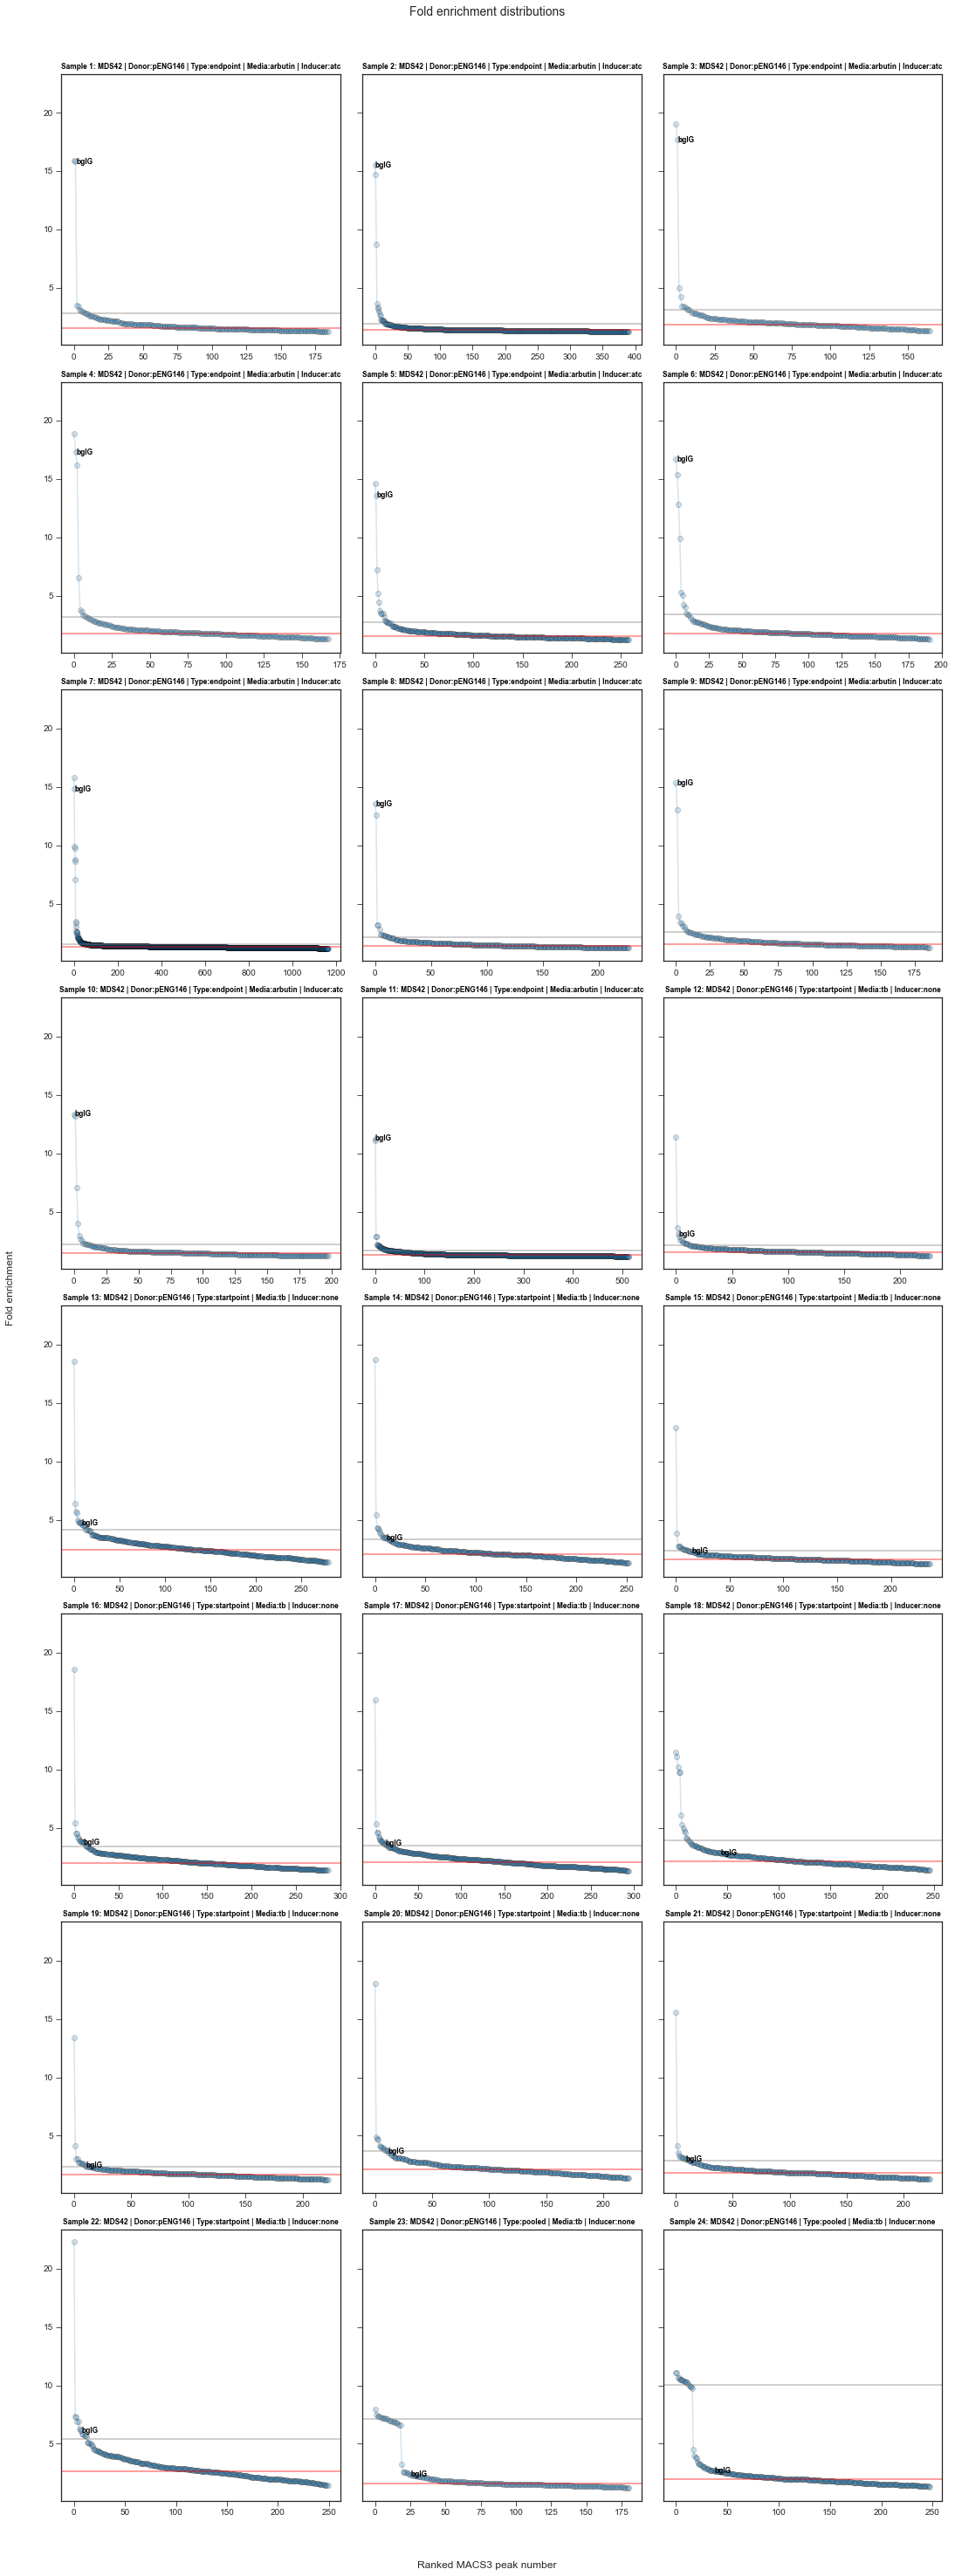

In [529]:
#metadata_zip_001_dedup = metadata_collection(peaks_directory_001_dedup)
#plot_all_ranked_distributions(5,2,metadata_zip_001_dedup,export_directory_001_dedup,metadatafile_001)

#metadata_zip_002_dedup = metadata_collection(peaks_directory_002_dedup)
#plot_all_ranked_distributions(5,2,metadata_zip_002_dedup,export_directory_002_dedup,metadatafile_002)

#metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
#plot_all_ranked_distributions(8,3,metadata_zip_003_dedup,export_directory_003_dedup,metadatafile_003)

#metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
#plot_all_ranked_distributions(8,3,metadata_zip_004_dedup,export_directory_004_dedup,metadatafile_004)

metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
plot_all_ranked_distributions(8,3,metadata_zip_005_dedup,export_directory_005_dedup,metadatafile_005)

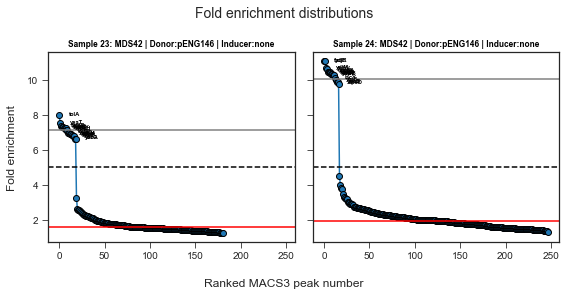

In [22]:
#metadata_zip_001_dedup = metadata_collection(peaks_directory_001_dedup)
#plot_paired_ranked_distributions(pairs_001,metadata_zip_001_dedup,export_directory_001_dedup,metadatafile_001)

#metadata_zip_002_dedup = metadata_collection(peaks_directory_002_dedup)
#plot_paired_ranked_distributions(pairs_002,metadata_zip_002_dedup,export_directory_002_dedup,metadatafile_002)

#metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
#plot_paired_ranked_distributions(pairs_003,metadata_zip_003_dedup,export_directory_003_dedup,metadatafile_003)

#metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
#plot_paired_ranked_distributions(pairs_004,metadata_zip_004_dedup,export_directory_004_dedup,metadatafile_004)

metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
plot_paired_ranked_distributions(pairs_005,metadata_zip_005_dedup,export_directory_005_dedup,metadatafile_005)


### Plot filtering effects and overlaps for the peaks

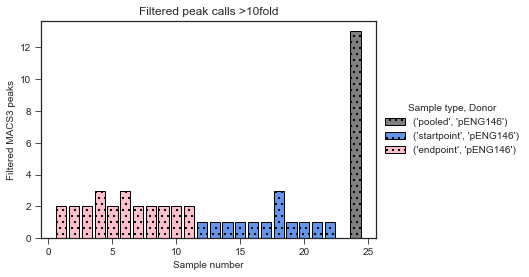

In [527]:
for x in range(2,11,2):
    #metadata_zip_001 = metadata_collection(peaks_directory_001)
    #filtered_001 = peaks_across_samples(x,metadatafile_001,metadata_zip_001,export_directory_001,False,True)
    #metadata_zip_001_dedup = metadata_collection(peaks_directory_001_dedup)
    #filtered_001_dedup = peaks_across_samples(x,metadatafile_001,metadata_zip_001_dedup,export_directory_001_dedup,False,True)


    #metadata_zip_002 = metadata_collection(peaks_directory_002)
    #filtered_002 = peaks_across_samples(x,metadatafile_002,metadata_zip_002,export_directory_002,False,True)

    #metadata_zip_003 = metadata_collection(peaks_directory_003)
    #filtered_003 = peaks_across_samples(x,metadatafile_003,metadata_zip_003,export_directory_003,False,True)
    #metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
    #filtered_003_dedup = peaks_across_samples(x,metadatafile_003,metadata_zip_003_dedup,export_directory_003_dedup,False,True)


    #metadata_zip_004 = metadata_collection(peaks_directory_004)
    #filtered_004 = peaks_across_samples(x,metadatafile_004,metadata_zip_004,export_directory_004,False,True)
    #metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
    #filtered_004_dedup = peaks_across_samples(x,metadatafile_004,metadata_zip_004_dedup,export_directory_004_dedup,False,True)


    #metadata_zip_005 = metadata_collection(peaks_directory_005)
    #filtered_005 = peaks_across_samples(x,metadatafile_005,metadata_zip_005,export_directory_005,False,True)
    metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
    filtered_005_dedup = peaks_across_samples(x,metadatafile_005,metadata_zip_005_dedup,export_directory_005_dedup,False,True)


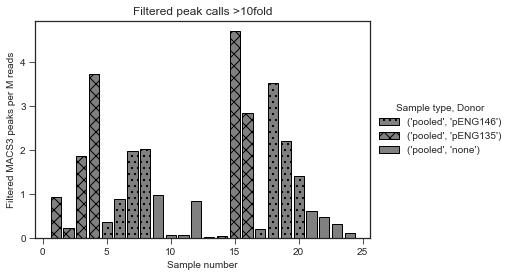

In [542]:
for x in range(0,12,2):
    metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
    filtered_003_dedup = peaks_across_samples(x,metadatafile_003,metadata_zip_003_dedup,export_directory_003_dedup,True,True)

In [ ]:
for q in range(0,20,1):

    #metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
    #possible_combinations_003,sample_dataframe_003 = collapse_and_compare(q,metadatafile_003,metadata_zip_003_dedup,\
                                                              #dedup_stats_003['dedup_read_num'],['inducer','donor_plasmid'],False,\
                                                             #export_directory_003_dedup)
    
    
    metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
    possible_combinations_004,sample_dataframe_004 = collapse_and_compare(q,metadatafile_004,metadata_zip_004_dedup,\
                                                              dedup_stats_004['dedup_read_num'],['sample_type','donor_plasmid'],False,\
                                                             export_directory_004_dedup)
    
    
    #metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
    #possible_combinations_005,sample_dataframe_005 = collapse_and_compare(q,metadatafile_005,metadata_zip_005_dedup,\
                                                              #dedup_stats_005['dedup_read_num'],['sample_type'],False,\
                                                             #export_directory_005_dedup)




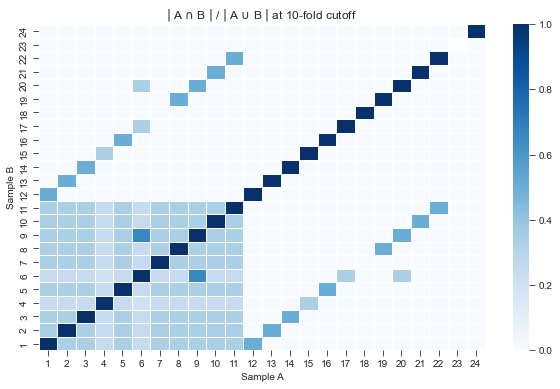

In [22]:
for x in range(2,12,2):
    #metadata_zip_001_dedup = metadata_collection(peaks_directory_001_dedup)
    #pairwise_intersection_001_dedup = pairwise_intersection_array(x,metadatafile_001,metadata_zip_001_dedup,'fraction_total')
    #pairwise_intersection_heatmap(x,pairwise_intersection_001_dedup,export_directory_001_dedup,'fraction_total')

    #metadata_zip_002_dedup = metadata_collection(peaks_directory_002_dedup)
    #pairwise_intersection_002_dedup = pairwise_intersection_array(x,metadatafile_002,metadata_zip_002_dedup,'fraction_total')
    #pairwise_intersection_heatmap(x,pairwise_intersection_002_dedup,export_directory_002_dedup,'fraction_total')
    
    #metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
    #pairwise_intersection_003_dedup = pairwise_intersection_array(x,metadatafile_003,metadata_zip_003_dedup,'fraction_total')
    #pairwise_intersection_heatmap(x,pairwise_intersection_003_dedup,export_directory_003_dedup,'fraction_total')


    #metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
    #pairwise_intersection_004_dedup = pairwise_intersection_array(x,metadatafile_004,metadata_zip_004_dedup,'fraction_total')
    #pairwise_intersection_heatmap(x,pairwise_intersection_004_dedup,export_directory_004_dedup,'fraction_total')

    metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
    pairwise_intersection_005_dedup = pairwise_intersection_array(x,metadatafile_005,metadata_zip_005_dedup,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_005_dedup,export_directory_005_dedup,'fraction_total')


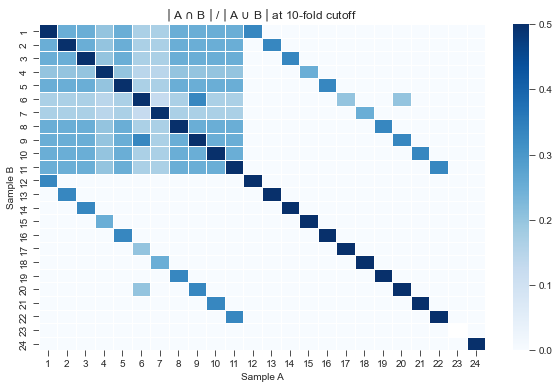

In [197]:
for x in range(2,12,2):
    metadata_zip_001 = metadata_collection(peaks_directory_001)
    pairwise_intersection_001 = pairwise_intersection_array(x,metadatafile_001,metadata_zip_001,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_001,export_directory_001,'fraction_total')

    metadata_zip_002 = metadata_collection(peaks_directory_002)
    pairwise_intersection_002 = pairwise_intersection_array(x,metadatafile_002,metadata_zip_002,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_002,export_directory_002,'fraction_total')

    metadata_zip_003 = metadata_collection(peaks_directory_003)
    pairwise_intersection_003 = pairwise_intersection_array(x,metadatafile_003,metadata_zip_003,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_003,export_directory_003,'fraction_total')


    metadata_zip_004 = metadata_collection(peaks_directory_004)
    pairwise_intersection_004 = pairwise_intersection_array(x,metadatafile_004,metadata_zip_004,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_004,export_directory_004,'fraction_total')

    metadata_zip_005 = metadata_collection(peaks_directory_005)
    pairwise_intersection_005 = pairwise_intersection_array(x,metadatafile_005,metadata_zip_005,'fraction_total')
    pairwise_intersection_heatmap(x,pairwise_intersection_005,export_directory_005,'fraction_total')


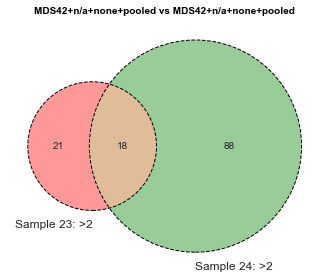

In [242]:
for x in range(2,4,2):
    metadata_zip_001 = metadata_collection(peaks_directory_001)
    pairwise_venn_diagram(pairs_001,metadata_zip_001,export_directory_001,metadatafile_001,x)

    metadata_zip_002 = metadata_collection(peaks_directory_002)
    pairwise_venn_diagram(pairs_002,metadata_zip_002,export_directory_002,metadatafile_002,x)

    metadata_zip_003 = metadata_collection(peaks_directory_003)
    pairwise_venn_diagram(pairs_003,metadata_zip_003,export_directory_003,metadatafile_003,x)

    metadata_zip_004 = metadata_collection(peaks_directory_004)
    pairwise_venn_diagram(pairs_004,metadata_zip_004,export_directory_004,metadatafile_004,x)

    metadata_zip_005 = metadata_collection(peaks_directory_005)
    pairwise_venn_diagram(pairs_005,metadata_zip_005,export_directory_005,metadatafile_005,x)




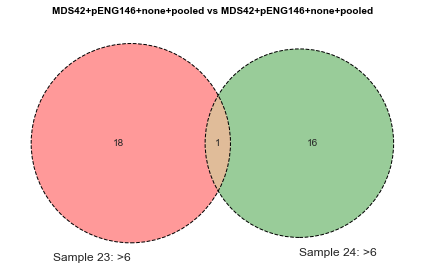

In [540]:
for x in range(2,8,2):
    #metadata_zip_001_dedup = metadata_collection(peaks_directory_001_dedup)
    #pairwise_venn_diagram(pairs_001,metadata_zip_001_dedup,export_directory_001_dedup,metadatafile_001,x)

    #metadata_zip_002 = metadata_collection(peaks_directory_002)
    #pairwise_venn_diagram(pairs_002,metadata_zip_002,export_directory_002,metadatafile_002,x)

    #metadata_zip_003_dedup = metadata_collection(peaks_directory_003_dedup)
    #pairwise_venn_diagram(pairs_003,metadata_zip_003_dedup,export_directory_003_dedup,metadatafile_003,x)

    #metadata_zip_004_dedup = metadata_collection(peaks_directory_004_dedup)
    #pairwise_venn_diagram(pairs_004,metadata_zip_004_dedup,export_directory_004_dedup,metadatafile_004,x)

    metadata_zip_005_dedup = metadata_collection(peaks_directory_005_dedup)
    pairwise_venn_diagram(pairs_005,metadata_zip_005_dedup,export_directory_005_dedup,metadatafile_005,x)

#### Between-sample comparisons

- Three timepoints for MAE-003,4 (scrape, overnight, atc+/-)
- All control samples for MAE-003,4
- Startpoint samples for MAE-005 with the controls from MAE-003 and MAE-004
- All of the startpoint GROWTH samples for MAE-005 pooled, compared to the NO-GROWTH
- Reads per 

### FUNCTIONS

In [9]:
## Plot graph of metrics
# Reads per sample
def reads_per_sample(metadatafile,export_directory,factor):
    plt.bar(metadatafile['sample_name'],metadatafile['total_reads_postQC'],color='cornflowerblue', edgecolor='black')
    plt.xticks(rotation=90)
    plt.ylabel('Reads passing fastp filters (%s)' % factor)
    plt.axhline(y=np.median(metadatafile['total_reads_postQC']), color='r', linestyle='-',alpha=0.5)
    plt.axhline(y=np.percentile(metadatafile['total_reads_postQC'],5), color='grey', linestyle='-',alpha=0.75)
    plt.axhline(y=np.percentile(metadatafile['total_reads_postQC'],95), color='grey', linestyle='-',alpha=0.75)

    # find outliers 
    def detect_outlier(data):
        # find q1 and q3 values
        q1, q3 = np.percentile(sorted(data), [25, 75])
        # compute IQR
        iqr = q3 - q1
        # find lower and upper bounds
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
        return outliers

    # input data
    outlier_samples = []
    outliers = detect_outlier((metadatafile['total_reads_postQC']))
    for outlier in outliers:
        outlier_sample = metadatafile['sample_name'].loc[metadatafile['total_reads_postQC'] == outlier]
        outlier_samples.append(list(outlier_sample)[0])

        for i,x in enumerate (metadatafile['sample_name']):
            if metadatafile['sample_name'][i] == list(outlier_sample)[0]:
                plt.annotate('##',(i, metadatafile['total_reads_postQC'][i]),textcoords="offset points",xytext=(0,2),ha='center',size='small', color='black', weight='semibold')

    print('Samples '+str(outlier_samples)+' are outliers')
    plt.savefig(export_directory+'reads_QC.svg', bbox_inches='tight', dpi=300)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)
    return



In [10]:
def metadata_collection(peaks_directory):

    ## iterate over files in the peaks file directory
    ## extract file names, sample names, and sample numbers

    ## collect data on the number of peaks for a certain set of cutoff values
    # the number at the end of num_peaks_n => num of peaks for >n-fold enrichment
    num_peaks_raw = []
    num_peaks_2 = []
    num_peaks_3 = []
    num_peaks_5 = []
    num_peaks_7 = []
    num_peaks_10 = []

    filenames = []
    sample_names = []
    sample_numbers = []
    for filename in glob.iglob(f'{peaks_directory}/*'):
        filenames.append(filename)

    filenames.sort()
    sample_number = 1
    for filename in filenames:
        sample_name = filename.split("/")[-1]
        sample_names.append(sample_name)
        #sample_number = int(sample_name.split("_")[0])
        sample_numbers.append(sample_number)
        sample_number +=1

    metadata_inputs = zip(filenames,sample_names,sample_numbers)
                        
    return metadata_inputs

In [11]:
def plot_all_ranked_distributions(num_rows,num_cols,metadata_zip,export_directory,metadatafile):
    ## set up an axis on which to plot all of the graphs for each figure
    fig,ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=False, sharey=True)
    fig.set_figheight(5*num_rows)
    fig.set_figwidth(5*num_cols)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Fold enrichment distributions", fontsize=14,y=1.01)
    fig.supxlabel('Ranked MACS3 peak number',y= -0.01)
    fig.supylabel('Fold enrichment',x=-0.01)

    ## iterate through files and plot
    for filename,sample_name,sample_number in metadata_zip:

        # add a new subplot iteratively
        ax = plt.subplot(num_rows, num_cols, sample_number)

        ## Import peaks data from the csv file
        current_datafile = pd.read_csv(filename,index_col=0)
        sorted_datafile = current_datafile.sort_values(by=['fold-enrichment'], axis=0, ascending=False, inplace=False)
        sorted_datafile.reset_index(drop=True, inplace=True)

        ## Plot ordered fold enrichment
        current_strain = metadatafile['strain_name'][sample_number-1]
        current_sample_type = metadatafile['sample_type'][sample_number-1]
        current_media = metadatafile['outgrowth_media'][sample_number-1]
        current_inducer = metadatafile['inducer'][sample_number-1]
        if 'donor_plasmid' in metadatafile.columns:
            current_donor = metadatafile['donor_plasmid'][sample_number-1]
        else:
            current_donor = 'undefined'

        # calculate the median and 95 centile of the fold change data
        median_foldchange = np.median(sorted_datafile['fold-enrichment'])
        percentile_95 = np.percentile(sorted_datafile['fold-enrichment'], 95)

        # plot the data on the current subplot
        ax.plot(sorted_datafile['fold-enrichment'],alpha=0.2,marker='o',markeredgecolor='black')
        ax.axhline(y=median_foldchange, color='r', linestyle='-',alpha=0.5)
        ax.axhline(y=percentile_95, color='grey', linestyle='-',alpha=0.5)
        ax.set_title('Sample '+str(sample_number)+": "+current_strain+" | Donor:"+current_donor+" | Type:"+current_sample_type+" | Media:"+current_media+" | Inducer:"+current_inducer,fontsize = 'small',color='black', weight='bold')


        # Loop through the data points and label specific ones
        for i, language in enumerate (sorted_datafile['fold-enrichment']):
            if sorted_datafile['gene1'][i] == 'bglG':
                plt.text(i+0.5, sorted_datafile['fold-enrichment'][i]-0.2, sorted_datafile['gene1'][i],size='small', color='black', weight='semibold')

    plt.tight_layout()
    plt.savefig(export_directory+'all_distributions.svg', bbox_inches='tight', dpi=300)
    plt.show()
    clear_output(wait=True)
    time.sleep(2)
    return


In [21]:
def plot_paired_ranked_distributions(pairs,metadata_zip,export_directory,metadatafile):
    label_cutoff = 5
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)
    
    for pair in pairs:
        fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
        fig.set_figheight(4)
        fig.set_figwidth(8)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle("Fold enrichment distributions", fontsize=14,y=0.99)
        fig.supxlabel('Ranked MACS3 peak number')
        fig.supylabel('Fold enrichment')
        
        member_no = 1
        for member in pair:

            ### PLOT FOR PAIR MEMBER 1
            # add a new subplot iteratively
            ax = plt.subplot(1, 2, member_no)
            ## Import peaks data from the csv file
            filename = filenames[member-1]
            current_datafile = pd.read_csv(filename,index_col=0)
            sorted_datafile = current_datafile.sort_values(by=['fold-enrichment'], axis=0, ascending=False, inplace=False)
            sorted_datafile.reset_index(drop=True, inplace=True)

            # Calculate median and percentiles
            median_foldchange = np.median(sorted_datafile['fold-enrichment'])
            percentile_95 = np.percentile(sorted_datafile['fold-enrichment'], 95)

            ## Plot ordered fold enrichment
            current_strain = metadatafile['strain_name'][member-1]
            current_sample_type = metadatafile['sample_type'][member-1]
            current_media = metadatafile['outgrowth_media'][member-1]
            current_inducer = metadatafile['inducer'][member-1]
            if 'donor_plasmid' in metadatafile.columns:
                current_donor = metadatafile['donor_plasmid'][member-1]
            else:
                current_donor = 'undefined'

            ax.plot(sorted_datafile['fold-enrichment'],alpha=1,marker='o',markeredgecolor='black')
            ax.axhline(y=median_foldchange, color='r', linestyle='-',alpha=1)
            ax.axhline(y=percentile_95, color='grey', linestyle='-',alpha=1)
            ax.axhline(y=5, color='black', linestyle='--',alpha=1)
            ax.set_title('Sample '+str(member)+": "+current_strain+" | Donor:"+current_donor+" | Inducer:"+current_inducer,fontsize = 'small',color='black', weight='bold')
            # Loop through the data points 
            for i, language in enumerate (sorted_datafile['fold-enrichment']):
                if sorted_datafile['fold-enrichment'][i] > label_cutoff:
                    plt.annotate(sorted_datafile['gene1'][i],(i, sorted_datafile['fold-enrichment'][i]),textcoords="offset points",xytext=(10,0),ha='left',size='xx-small', color='black', weight='semibold')

            member_no +=1
            
        plt.tight_layout()
        plt.savefig(export_directory+'pair_'+str(pair[0])+'_'+str(pair[1])+'.svg', bbox_inches='tight', dpi=300)
        plt.show()
        clear_output(wait=True)
        time.sleep(2)
    return

In [13]:
def peaks_across_samples(cutoff_value,metadatafile,metadata_zip,export_directory,read_norm,plot,read_num_list):
    
    
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)
    
    num_peaks_filtered = []
    for filename in filenames:
        ## Import peaks data from the csv file
        current_datafile = pd.read_csv(filename,index_col=0)
        num_peaks_filtered.append(current_datafile[current_datafile['fold-enrichment'] > cutoff_value].shape[0])
    
    if plot == True:
        if read_norm == True:
            bar_heights = np.divide(num_peaks_filtered, read_num_list)
            y_label = 'Filtered MACS3 peaks per M reads'
            output = export_directory+'total_peaks_'+str(cutoff_value)+'_fold_enriched_readnorm.svg'

        else:
            bar_heights = num_peaks_filtered
            y_label = 'Filtered MACS3 peaks'
            output = export_directory+'total_peaks_'+str(cutoff_value)+'_fold_enriched.svg'
            
        
        
        
        labels = metadatafile['sample_type'].unique()
        labels2 = metadatafile['donor_plasmid'].unique()
        colors = {'startpoint': 'cornflowerblue', 'endpoint': 'pink', 'scrape': 'green','overnight': 'orange', 'pooled': 'grey'}
        hatches = {'pENG135': 'xx','pENG146':'..','none': ''}
        
        from matplotlib import patches

        from itertools import combinations, product
        def pairs(*lists):
            for t in combinations(lists, 2):
                for pair in product(*t):
                    #Don't output pairs containing duplicated elements 
                    if pair[0] != pair[1]:
                        yield pair

        import matplotlib.patches as mpatches

        #Feed the output of `pairs` into a set to eliminate duplicate tuples
        list_combo = set(pairs(labels,labels2))
        #for x in output:
            #print(hatches[x[1]])

        handles = [mpatches.Patch(edgecolor = 'k',facecolor=colors[l[0]],hatch=hatches[l[1]]) for l in list_combo]

        plt.bar(sample_numbers, bar_heights, width=0.8, bottom=None, align='center',\
                color=[colors[i] for i in metadatafile['sample_type']],\
                hatch=[hatches[z] for z in metadatafile['donor_plasmid']],\
                edgecolor='black')
        plt.legend(handles,list_combo, title="Sample type, Donor",loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Filtered peak calls >'+str(cutoff_value)+ 'fold')
        plt.xlabel('Sample number')
        plt.ylabel(y_label)
        plt.savefig(output, bbox_inches='tight', dpi=300)
        clear_output(wait=True)
        time.sleep(2)

        plt.show()
        return num_peaks_filtered
    else:
        return num_peaks_filtered


In [14]:
def pairwise_intersection_array(cutoff,metadatafile,metadata_zip,norm_type):
    
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)

    pairwise_intersections = np.zeros((metadatafile.shape[0],metadatafile.shape[0]))
    pairwise_intersections_fraction_total = np.zeros((metadatafile.shape[0],metadatafile.shape[0]))
    pairwise_intersections_fraction_set1 = np.zeros((metadatafile.shape[0],metadatafile.shape[0]))
    pairwise_intersections_fraction_set2 = np.zeros((metadatafile.shape[0],metadatafile.shape[0]))

    filenumber_1 = 0
    for filename_1 in filenames:
        venn_datafile_1 = pd.read_csv(filename_1,index_col=0)
        filtered_datafile_1 = venn_datafile_1[venn_datafile_1['fold-enrichment'] > cutoff]
        set1 = set(filtered_datafile_1['gene1'])

        filenumber_2 = 0
        for filename_2 in filenames:
            venn_datafile_2 = pd.read_csv(filename_2,index_col=0)
            filtered_datafile_2 = venn_datafile_2[venn_datafile_2['fold-enrichment'] > cutoff]
            set2 = set(filtered_datafile_2['gene1'])
            
            if len(set1) != 0 and len(set2) != 0:
                pairwise_intersections[filenumber_1,filenumber_2] = len(set1.intersection(set2))
                pairwise_intersections_fraction_total[filenumber_1,filenumber_2] = len(set1.intersection(set2))/len(set1.union(set2))
                pairwise_intersections_fraction_set1[filenumber_1,filenumber_2] = len(set1.intersection(set2))/len(set1)
                pairwise_intersections_fraction_set2[filenumber_1,filenumber_2] = len(set1.intersection(set2))/len(set2)
            elif len(set1) == 0 and len(set2) == 0:
                pairwise_intersections[filenumber_1,filenumber_2] = None
                pairwise_intersections_fraction_total[filenumber_1,filenumber_2] = None
                pairwise_intersections_fraction_set1[filenumber_1,filenumber_2] = None
                pairwise_intersections_fraction_set2[filenumber_1,filenumber_2] = None
            elif len(set1) == 0 and len(set2) != 0:
                pairwise_intersections[filenumber_1,filenumber_2] = len(set1.intersection(set2))
                pairwise_intersections_fraction_total[filenumber_1,filenumber_2] = len(set1.intersection(set2))/(len(set1)+len(set2))
                pairwise_intersections_fraction_set1[filenumber_1,filenumber_2] = None
                pairwise_intersections_fraction_set2[filenumber_1,filenumber_2] = len(set1.intersection(set2))/len(set2)
            elif len(set1) != 0 and len(set2) == 0:
                pairwise_intersections[filenumber_1,filenumber_2] = len(set1.intersection(set2))
                pairwise_intersections_fraction_total[filenumber_1,filenumber_2] = len(set1.intersection(set2))/(len(set1)+len(set2))
                pairwise_intersections_fraction_set1[filenumber_1,filenumber_2] = len(set1.intersection(set2))/len(set1)
                pairwise_intersections_fraction_set2[filenumber_1,filenumber_2] = None


            filenumber_2 += 1


        filenumber_1 += 1

    
    pairwise_intersections_array = pd.DataFrame(pairwise_intersections, columns = sample_numbers,index=sample_numbers)
    pairwise_intersections_fraction_total_array = pd.DataFrame(pairwise_intersections_fraction_total, columns = sample_numbers,index=sample_numbers)
    pairwise_intersections_fraction_set1_array = pd.DataFrame(pairwise_intersections_fraction_set1, columns = sample_numbers,index=sample_numbers)
    pairwise_intersections_fraction_set2_array = pd.DataFrame(pairwise_intersections_fraction_set2, columns = sample_numbers,index=sample_numbers)
    
    if norm_type == 'raw':
        return pairwise_intersections_array
    elif norm_type == 'fraction_total':
        return pairwise_intersections_fraction_total_array
    elif norm_type == 'fraction_set1':
        return pairwise_intersections_fraction_set1_array
    elif norm_type == 'fraction_set2':
        return pairwise_intersections_fraction_set2_array
        

In [15]:
def pairwise_intersection_heatmap(cutoff,pairwise_intersection_array,export_directory,norm_type):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(pairwise_intersection_array,cmap ='Blues',linewidths=1,xticklabels=True, yticklabels=True)
    plt.xlabel('Sample A')
    plt.ylabel('Sample B')
    if norm_type == 'raw':
        ax.set_title(r'$\vert$ A $\cap$ B $\vert$ at %s-fold cutoff' % str(cutoff))
    elif norm_type == 'fraction_total':
        ax.set_title(r'$\vert$ A $\cap$ B $\vert$ / $\vert$ A $\cup$ B $\vert$ at %s-fold cutoff' % str(cutoff))
    elif norm_type == 'fraction_set1':
        ax.set_title(r'$\vert$ A $\cap$ B $\vert$ / $\vert$ A $\vert$ at %s-fold cutoff' % str(cutoff))
    elif norm_type == 'fraction_set2':
        ax.set_title(r'$\vert$ A $\cap$ B $\vert$ / $\vert$ B $\vert$ at %s-fold cutoff' % str(cutoff))
    
    ax.invert_yaxis()
    
    plt.savefig(export_directory+'pairwise_intersection'+str(cutoff)+'_cutoff.svg', bbox_inches='tight', dpi=300)
    plt.show()
    clear_output(wait=True)
    time.sleep(2)
    

In [16]:
def pairwise_venn_diagram(pairs,metadata_zip,export_directory,metadatafile,cutoff):
    
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)
    
    for pair in pairs:
        venn_datafile_1 = pd.read_csv(filenames[pair[0]-1],index_col=0)
        venn_datafile_2 = pd.read_csv(filenames[pair[1]-1],index_col=0)

        set1_filtered = venn_datafile_1[venn_datafile_1['fold-enrichment'] > cutoff]
        set2_filtered = venn_datafile_2[venn_datafile_2['fold-enrichment'] > cutoff]

        set1_genes = set(set1_filtered['gene1'])
        set2_genes = set(set2_filtered['gene1'])

        current_strain_1 = metadatafile['strain_name'][pair[0]-1]
        current_sample_type_1 = metadatafile['sample_type'][pair[0]-1]
        current_media_1 = metadatafile['outgrowth_media'][pair[0]-1]
        current_inducer_1 = metadatafile['inducer'][pair[0]-1]

        current_strain_2 = metadatafile['strain_name'][pair[1]-1]
        current_sample_type_2 = metadatafile['sample_type'][pair[1]-1]
        current_media_2 = metadatafile['outgrowth_media'][pair[1]-1]
        current_inducer_2 = metadatafile['inducer'][pair[1]-1]

        if 'donor_plasmid' in metadatafile.columns:
            current_donor_1 = metadatafile['donor_plasmid'][pair[0]-1]
            current_donor_2 = metadatafile['donor_plasmid'][pair[1]-1]
        else:
            current_donor_1 = 'n/a'
            current_donor_2 = 'n/a'

        v = venn2([set1_genes, set2_genes], set_labels = ('Sample '+str(pair[0])+': >'+str(cutoff), 'Sample '+str(pair[1])+': >'+str(cutoff)))        
        c = venn2_circles([set1_genes, set2_genes], linestyle='dashed')
        c[0].set_lw(1.0)
        c[1].set_lw(1.0)
        plt.title(current_strain_1+'+'+current_donor_1+'+'+current_inducer_1+'+'+current_sample_type_1+\
                     ' vs '+current_strain_2+'+'+current_donor_2+'+'+current_inducer_2+'+'+current_sample_type_2,fontsize = 'medium',color='black', weight='bold')
        plt.tight_layout()
        plt.savefig(export_directory+'venn_samples_'+str(pair)+'_'+str(cutoff)+'-fold_list_overlap.svg', bbox_inches='tight', dpi=300)
        plt.show()
        clear_output(wait=True)
        time.sleep(2)



In [17]:
def threeway_venn_diagram(triples,metadata_zip,export_directory,metadatafile,cutoff):
    
        
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)
    
    for triple in triples:
        venn_datafile_1 = pd.read_csv(filenames[triple[0]-1],index_col=0)
        venn_datafile_2 = pd.read_csv(filenames[triple[1]-1],index_col=0)
        venn_datafile_3 = pd.read_csv(filenames[triple[2]-1],index_col=0)


        set1_filtered = venn_datafile_1[venn_datafile_1['fold-enrichment'] > cutoff]
        set2_filtered = venn_datafile_2[venn_datafile_2['fold-enrichment'] > cutoff]
        set3_filtered = venn_datafile_3[venn_datafile_3['fold-enrichment'] > cutoff]


        set1_genes = set(set1_filtered['gene1'])
        set2_genes = set(set2_filtered['gene1'])
        set3_genes = set(set3_filtered['gene1'])


        current_strain_1 = metadatafile['strain_name'][triple[0]-1]
        current_sample_type_1 = metadatafile['sample_type'][triple[0]-1]
        current_media_1 = metadatafile['outgrowth_media'][triple[0]-1]
        current_inducer_1 = metadatafile['inducer'][triple[0]-1]
        
        current_strain_2 = metadatafile['strain_name'][triple[1]-1]
        current_sample_type_2 = metadatafile['sample_type'][triple[1]-1]
        current_media_2 = metadatafile['outgrowth_media'][triple[1]-1]
        current_inducer_2 = metadatafile['inducer'][triple[1]-1]
        
        current_strain_3 = metadatafile['strain_name'][triple[2]-1]
        current_sample_type_3 = metadatafile['sample_type'][triple[2]-1]
        current_media_3 = metadatafile['outgrowth_media'][triple[2]-1]
        current_inducer_3 = metadatafile['inducer'][triple[2]-1]


        if 'donor_plasmid' in metadatafile.columns:
            current_donor_1 = metadatafile['donor_plasmid'][triple[0]-1]
            current_donor_2 = metadatafile['donor_plasmid'][triple[1]-1]
            current_donor_3 = metadatafile['donor_plasmid'][triple[2]-1]

        else:
            current_donor_1 = 'n/a'
            current_donor_2 = 'n/a'
            current_donor_3 = 'n/a'

            
        v = venn3([set1_genes, set2_genes,set3_genes], set_labels = ('Sample '+str(triple[0])+': >'+str(cutoff), 'Sample '+str(triple[1])+': >'+str(cutoff), 'Sample '+str(triple[2])+': >'+str(cutoff)))
        v.get_patch_by_id('100').set_alpha(1.0)
        c = venn3_circles([set1_genes, set2_genes,set3_genes], linestyle='dashed')
        c[0].set_lw(1.0)
        c[1].set_lw(1.0)
        c[2].set_lw(1.0)
        
        plt.title(current_donor_1+'+'+current_inducer_1+'+'+current_sample_type_1+\
                     ' vs '+current_donor_2+'+'+current_inducer_2+'+'+current_sample_type_2+\
                  ' vs '+current_donor_3+'+'+current_inducer_3+'+'+current_sample_type_3,fontsize = 'small',color='black', weight='bold')
        plt.tight_layout()
        plt.savefig(export_directory+'venn_samples_'+str(triple)+'_'+str(cutoff)+'-fold_list_overlap.svg', bbox_inches='tight', dpi=300)
        plt.show()
        clear_output(wait=True)
        time.sleep(2)





In [18]:
def dedup_read_comparison(dedup_stats,export_directory):

    
    x = np.arange(len(dedup_stats['sample_name']))  # the label locations
    width = 0.3  # the width of the bars
    names = list(dedup_stats['sample_name'])

    fig, ax = plt.subplots()

    rects1 = ax.bar((x+1) - width/2, dedup_stats['original_read_num'], width, label='Raw',color = '#fcb5ac', edgecolor='black')
    rects2 = ax.bar((x+1) + width/2, dedup_stats['dedup_read_num'], width, label='Unique', color = '#b5e5cf', edgecolor='black')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('No. reads [post alignment]')
    ax.set_xlabel('Sample number')
    ax.set_title('UMI Tools deduplication',y=1.1)
    ax.set_xticks(x+1)
    ax.legend()

    ax.bar_label(rects1, labels=['%.1f%%' % e for e in dedup_stats['duplication_rate']],
             padding=3, color='k', fontsize=10,rotation='vertical')
    
    fig.set_figheight(6)
    fig.set_figwidth(10)
    fig.tight_layout()
    plt.savefig(export_directory+'UMI_filtering_results.svg', bbox_inches='tight', dpi=300)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)

    return

In [19]:
def collapse_and_compare(cutoff_value,metadatafile,metadata_zip,dedup_reads_list,ordered_column_groupings,normalised,export_directory):
    
    
    filenames = []
    sample_names = []
    sample_numbers = []
    
    for filename,sample_name,sample_number in metadata_zip:
        filenames.append(filename)
        sample_names.append(sample_name)
        sample_numbers.append(sample_number)
    
    num_peaks_filtered = []
    for filename in filenames:
        ## Import peaks data from the csv file
        current_datafile = pd.read_csv(filename,index_col=0)
        filtered_datafile = current_datafile[current_datafile['fold-enrichment'] > cutoff_value]
        num_peaks_filtered.append(filtered_datafile.shape[0])
        

    read_norm_peak_num = np.divide(num_peaks_filtered, dedup_reads_list/1e6)
    sample_dataframe = metadatafile.copy()
    sample_dataframe['peaks'] = num_peaks_filtered
    sample_dataframe['peaks_pmr'] = read_norm_peak_num
    possible_combinations = sample_dataframe.groupby(ordered_column_groupings).size()
    
    print()
    
    df_tips = sample_dataframe
    groups = df_tips[ordered_column_groupings].astype(str).agg('.'.join, axis=1)
    df_tips['Groups'] = groups
    
    
    sub_categories = []
    maj_categories = []
    
    if len(ordered_column_groupings) > 1:
        for category in groups.unique():

            sub_cats = category.split('.')[1:]
            maj_cat = category.split('.')[0]
            sub_cats = '.'.join(sub_cats)
            #print(sub_cats)
            sub_categories.append(sub_cats)
            maj_categories.append(maj_cat)


        unique_subcategories = np.unique(sub_categories)
        print(len(unique_subcategories))
        print(unique_subcategories)
        unique_majorcategories = np.unique(maj_categories)

        stat_pairs = []
        for unique_sub_category in unique_subcategories:
            current_pair = []
            for unique_maj_category in unique_majorcategories:
                current_pair.append(unique_maj_category+'.'+unique_sub_category)

            stat_pairs.append(current_pair)
        final_pair_list = stat_pairs

    elif len(ordered_column_groupings) == 1:
        stat_pairs = []
        from itertools import combinations
        stat_pairs_list = [",".join(map(str, comb)) for comb in combinations(groups.unique(), 2)]
        for pair in stat_pairs_list:
            current_pair = [0,0]
            current_pair[0] = pair.split(',')[0]
            current_pair[1] = pair.split(',')[1]
            stat_pairs.append(current_pair)
        pruned_pairs = []
        for pair in stat_pairs:
            if possible_combinations[pair[0]] == possible_combinations[pair[1]]:
                pruned_pairs.append(pair)
        final_pair_list = pruned_pairs
                
    
    
    
    plt.figure(figsize=(10, 10))
    
    
    if normalised == True:
        ax = sns.boxplot(x='Groups', y='peaks_pmr',hue=ordered_column_groupings[0], data=df_tips)
        add_stat_annotation(ax, data=df_tips, x='Groups', y='peaks_pmr',
                    box_pairs=final_pair_list,
                    test='Wilcoxon', text_format='star', loc='outside', verbose=2)

    
        sns.swarmplot(x='Groups', y='peaks_pmr', data=df_tips, color=".25")
        plt.xticks(
            rotation=90, 
            fontweight='light',
            fontsize='small'  
                )
        plt.ylabel('MACS3 Peaks per M reads for '+str(cutoff_value)+'-fold cutoff')

    if normalised == False:
        ax1 = sns.boxplot(x='Groups', y='peaks',hue=ordered_column_groupings[0], data=df_tips)
        add_stat_annotation(ax1, data=df_tips, x='Groups', y='peaks',
                    box_pairs=final_pair_list,
                    test='Wilcoxon', text_format='star', loc='outside', verbose=2)

    
        ax2=sns.swarmplot(x='Groups', y='peaks', data=df_tips, color=".25")
        plt.xticks(
            rotation=90, 
            fontweight='light',
            fontsize='small'  
                )
        plt.ylabel('MACS3 Peaks for '+str(cutoff_value)+'-fold cutoff')
    
    plt.tight_layout()
    plt.savefig(export_directory+'aggregate_sample_'+str(cutoff_value)+'-fold_list_overlap.svg', bbox_inches='tight', dpi=300)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)


    
    return possible_combinations, sample_dataframe